## Econ 412
### UCLA, Master of Quantitative Economics
#### Dr. Randall R. Rojas

# Linear Model Selection and Regularization

## I. Examples of Ridge, LASSO, and Elastic Nets

## Ridge Example
Example adapted from  [J. Warmenhoven](https://github.com/JWarmenhoven/ISLR-python).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet as gln

# pip install glmnet
# Note: This is a wrapper for R's glmnet

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV  
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# Load Baseball players dataset
df = pd.read_csv('Data/Hitters.csv').dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

###  (a)  Data exploration/partioning

In [3]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [4]:
# Note: The variables League, Division, and NewLeague have 'strings' as their values, therefore, 
# we'll convert them to dummy variables with  1, 0 
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB
        League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
Player                                                                      
1              0         1           0           1            0            1
2              1         0           0           1            1            0
3              0         1           1           0            0            1
4              0         1           1           0            0            1
5              1         0           0           1            1            0

In [5]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

In [6]:
# Verify the feature space (predictors)
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [7]:
# Note: These were exported from R to better match the textbook results
X_train = pd.read_csv('Data/Hitters_X_train.csv',index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

# Alternatively you do:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

### (b)  Fit a Ridge model (using sklearn)
Note: R's `glmnet` uses the penalty factor  $\frac{\lambda}{2}|\beta|^2$ but sklearn uses $\frac{\alpha}{N}|\beta|^2$, hence the use of $\alpha$ below. 

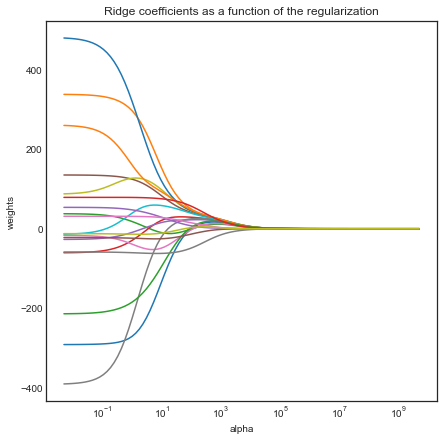

In [8]:
# Generate different values of alpha to fit different Ridge models
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []
 
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(7, 7))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

In [10]:
# Example, set alpha = 4 hard set
ridge2 = Ridge(alpha=4)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
print('MSE = ', mean_squared_error(y_test, pred))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

MSE =  97383.68965102118


AtBat         -161.784058
Hits           118.911404
HmRun           52.645719
Runs           -43.295947
RBI             37.339573
Walks          138.214992
Years         -106.916784
CAtBat         -21.080864
CHits          115.933862
CHmRun         -17.949420
CRuns          239.723217
CRBI           -17.945273
CWalks         -59.754770
PutOuts         21.752383
Assists        -68.676906
Errors          89.610291
League_N        31.048268
Division_W     -13.553466
NewLeague_N      4.350305
dtype: float64

In [11]:
# Example, set alpha = 10^10 seems like overkill
# The larger the value of alpha the greater the number of coeffs -->0
# With  this large  value, all the coeffs -->0
ridge2 = Ridge(alpha=10**10)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
print('MSE = ', mean_squared_error(y_test, pred))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

MSE =  193253.09707951872


AtBat          2.291553e-06
Hits           2.428111e-06
HmRun          2.051677e-06
Runs           2.372252e-06
RBI            2.538921e-06
Walks          2.974270e-06
Years          1.572334e-06
CAtBat         2.507043e-06
CHits          2.666936e-06
CHmRun         2.280416e-06
CRuns          2.839982e-06
CRBI           2.526355e-06
CWalks         2.544939e-06
PutOuts        4.880225e-07
Assists       -1.149268e-06
Errors         2.067779e-06
League_N       5.324293e-07
Division_W     5.051366e-07
NewLeague_N    5.291999e-07
dtype: float64

### (c) Compute the regularization path using RidgeCV
Rather than figuring out what $\alpha$ to use, we can do so automatically via CV.

In [12]:
# Perform CV and figure out the best lambda, best way to get alpha
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)
print('Ridge alpha =', ridgecv.alpha_)

Ridge alpha = 115.5064850041579


In [13]:
# Estimate the Ridge Model using the alpha above
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
print('MSE = ', mean_squared_error(y_test, ridge2.predict(scale(X_test))))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

MSE =  97384.92959172589


AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

### (c) Fit a Ridge model (using glmnet)
Note: `glmnet` was created in R, and has all sorts of helpful diagnostics worth exploring. Python's version has some limited functionality.

In [14]:
# Generate different values of lambda to fit different Ridge models
grid = 10**np.linspace(10,-2,100)

# Fit the Ridge model for all choices of lambda
# Note: Recall that Ridge  = Elastic Net w/ alpha = 0
ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

ElasticNet(alpha=0,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]))

In [15]:
# To find the best choice of lambda, we can use ridge3.lambda_best_ or ridge3.lambda_max_
ridge3.lambda_best_

array([705.48023107])

In [16]:
#  Look at the estimates for a particular path (in this case 49)
ridge3.lambda_path_[49]
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)
#  the predict() method does not give you the regression coefficients for lambda values not in the lambda_path. 

Intercept: 407.356


AtBat          0.037
Hits           0.138
HmRun          0.525
Runs           0.231
RBI            0.240
Walks          0.290
Years          1.108
CAtBat         0.003
CHits          0.012
CHmRun         0.088
CRuns          0.023
CRBI           0.024
CWalks         0.025
PutOuts        0.016
Assists        0.003
Errors        -0.021
League_N       0.085
Division_W    -6.215
NewLeague_N    0.301
dtype: float64

In [17]:
# Example using lambda = 4
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.values.ravel())
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
print('MSE = ', mean_squared_error(y_test.values.ravel(), pred))

MSE =  101036.83230892863


### Choose  $\lambda$ via CV

lambda max = 589.1835375713937
lambda best = [1639.43819209]


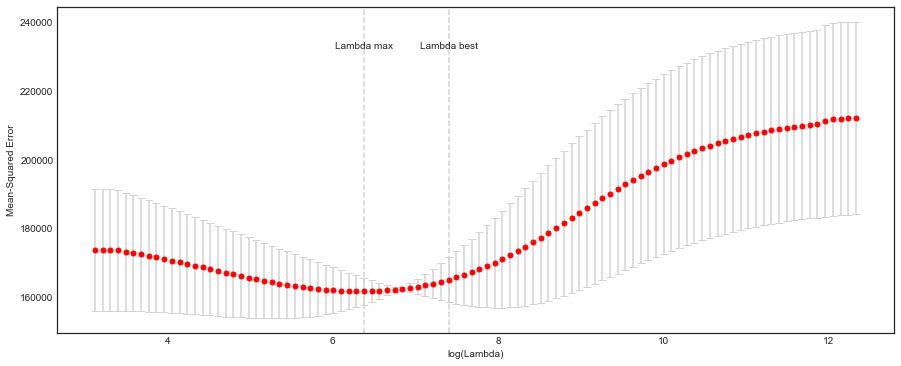

In [18]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.values.ravel())
# Lambda with best CV performance
print('lambda max =',ridge5.lambda_max_ )

# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
print('lambda best =',ridge5.lambda_best_)

plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [19]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
print('MSE = ',mean_squared_error(y_test, pred))

MSE =  98403.24355011512


In [20]:
# Fit model to entire dataset
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error', n_splits=10)
ridge6.fit(X, y)
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

AtBat           -0.681594
Hits             2.772311
HmRun           -1.365704
Runs             1.014812
RBI              0.713030
Walks            3.378558
Years           -9.066826
CAtBat          -0.001200
CHits            0.136102
CHmRun           0.697992
CRuns            0.295890
CRBI             0.257072
CWalks          -0.278966
PutOuts          0.263887
Assists          0.169878
Errors          -3.685656
League_N        53.209503
Division_W    -122.834334
NewLeague_N    -18.102528
dtype: float64

## $\color{blue}{\text{Simple Ridge (almost automatic) Estimate}}$

In [21]:
# Step 1: Use CV to get the best alpha
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

# Step 2: Estimate the model w/ best alpha
ridge_best = Ridge(alpha=ridgecv.alpha_)
ridge_best.fit(scale(X_train), y_train)

# Step 3: Print model estimates
print(list(zip(ridge_best.coef_, X)))

# Step 4: Print Error Metrics
print('R^2 Training Set', round(ridge_best.score(scale(X_train), y_train)*100, 2))
print('R^2 Test Set', round(ridge_best.score(scale(X_test), y_test)*100, 2))

[(array([  7.57677107,  22.5960297 ,  18.97199036,  20.19394492,
        21.063875  ,  55.71328133,  -4.68714918,  20.49689187,
        29.23024691,  14.29312413,  35.88178784,  20.21217197,
        24.4197681 ,  16.12890973, -44.10226357,  54.62450342,
         5.77146366,  -0.29371336,  11.13751806]), 'AtBat')]
R^2 Training Set 39.15
R^2 Test Set 49.46


## LASSO Example
Example adapted from  [J. Warmenhoven](https://github.com/JWarmenhoven/ISLR-python).

### (a) Fit a LASSO model (using sklearn)

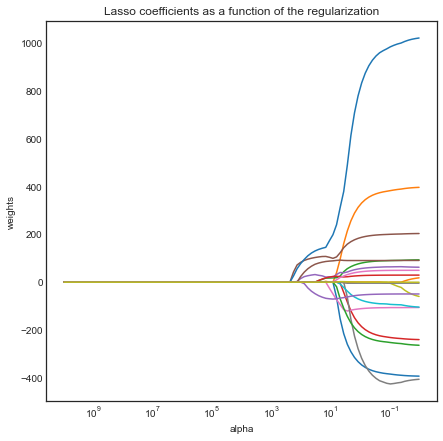

In [22]:
# Generate different values of alpha to fit different Ridge models
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
plt.figure(figsize=(7, 7))
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

### (b) Choose  $\lambda$ via CV

In [23]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(cv=10, max_iter=10000)

In [24]:
lassocv.alpha_

30.01382256446427

In [25]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
print('MSE = ',mean_squared_error(y_test, lasso.predict(scale(X_test))))

MSE =  102924.90954696966


In [26]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

### (c) Fit a LASSO model (using glmnet)

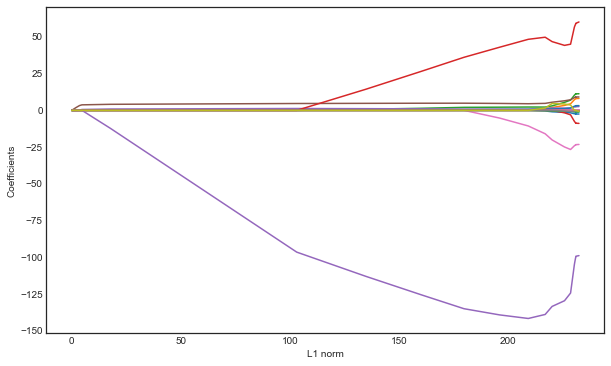

In [27]:
# Fit the Ridge model for all choices of lambda
# Note: Recall that Ridge  = Elastic Net w/ alpha = 1
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso2.fit(X_train, y_train.values.ravel())
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

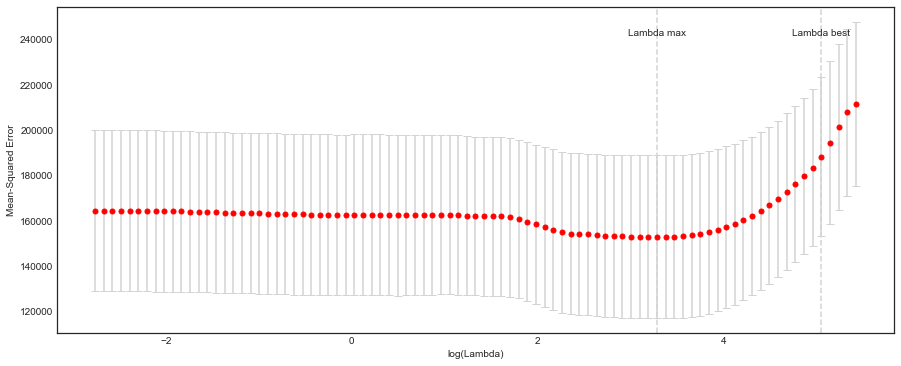

In [28]:
#Let glmnet() create a grid to use in CV
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.values.ravel())
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [29]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
print('MSE = ',mean_squared_error(y_test, pred))

MSE =  101294.328523177


In [30]:
# Fit model to entire dataset
lasso4 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso4.fit(X, y)
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

AtBat           -1.321629
Hits             5.168316
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks            4.320427
Years           -8.161760
CAtBat           0.000000
CHits            0.000000
CHmRun           0.425041
CRuns            0.582448
CRBI             0.398480
CWalks          -0.434668
PutOuts          0.266217
Assists          0.129877
Errors          -1.673647
League_N        30.707794
Division_W    -119.069986
NewLeague_N      0.000000
dtype: float64

## $\color{blue}{\text{Simple LASSO (almost automatic)}}$

In [31]:
# Step 1: Use CV to get the best alpha
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

# Step 2: Estimate the model w/ best alpha
lasso_best = Lasso(alpha=lassocv.alpha_)
lasso_best.fit(scale(X_train), y_train)

# Step 3: Print model estimates
print(list(zip(lasso_best.coef_, X)))

# Step 4: Print Error Metrics
print('R^2 Training Set', round(lasso_best.score(scale(X_train), y_train)*100, 2))
print('R^2 Test Set', round(lasso_best.score(scale(X_test), y_test)*100, 2))

[(0.0, 'AtBat'), (0.0, 'Hits'), (2.154218984758508, 'HmRun'), (0.0, 'Runs'), (30.83555951721413, 'RBI'), (104.07152805084242, 'Walks'), (-0.0, 'Years'), (0.0, 'CAtBat'), (0.0, 'CHits'), (0.0, 'CHmRun'), (132.85809529141193, 'CRuns'), (0.0, 'CRBI'), (0.0, 'CWalks'), (1.8961849090207357, 'PutOuts'), (-51.058751654587645, 'Assists'), (76.77964130536249, 'Errors'), (0.0, 'League_N'), (0.0, 'Division_W'), (0.0, 'NewLeague_N')]
R^2 Training Set 41.12
R^2 Test Set 46.58


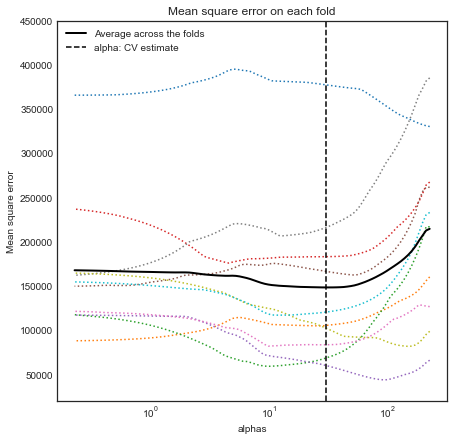

In [32]:
# Figure adapted from: 
#https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/

model = lassocv
plt.figure(figsize=(7, 7))
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 20000, 450000
plt.ylim(ymin, ymax);



## $\color{blue}{\text{Simple Elastic Net (almost automatic)}}$

In [33]:
# Step 1: Use CV to get the best alpha
enetcv = ElasticNetCV(cv=10, max_iter=10000)
enetcv.fit(scale(X_train), y_train.values.ravel())

# Step 2: Estimate the model w/ best alpha
enet_best = ElasticNet(alpha=enetcv.alpha_)
enet_best.fit(scale(X_train), y_train)

# Step 3: Print model estimates
print(list(zip(enet_best.coef_, X)))

# Step 4: Print Error Metrics
print('R^2 Training Set', round(enet_best.score(scale(X_train), y_train)*100, 2))
print('R^2 Test Set', round(enet_best.score(scale(X_test), y_test)*100, 2))

[(8.059480874304844, 'AtBat'), (22.45444074423237, 'Hits'), (18.64049489338871, 'HmRun'), (20.16720163282034, 'Runs'), (21.029466624476473, 'RBI'), (54.83811319172766, 'Walks'), (-2.948150006543679, 'Years'), (20.10753082399901, 'CAtBat'), (28.57674082599617, 'CHits'), (14.10759320213763, 'CHmRun'), (35.09469800682518, 'CRuns'), (19.895377465575088, 'CRBI'), (24.058891725904278, 'CWalks'), (15.591533403859403, 'PutOuts'), (-42.88162271065065, 'Assists'), (53.472176251924886, 'Errors'), (5.228508267855586, 'League_N'), (0.0, 'Division_W'), (10.779613757792495, 'NewLeague_N')]
R^2 Training Set 38.92
R^2 Test Set 49.32


## II. Examples PCA and Partial Regression

## PCA Example
Note: Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R

### (a) Loadings

In [34]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)  #   Loadings
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


### (b) Principal Components

In [35]:
print(X_reduced.shape) #   Principal Components
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


### (c) Variance explained by the PCs

marginal increase results in tradeoff of interpretability, I'd choose 96.2 or 97.

In [36]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

### (d) PCA using CV with Shuffle

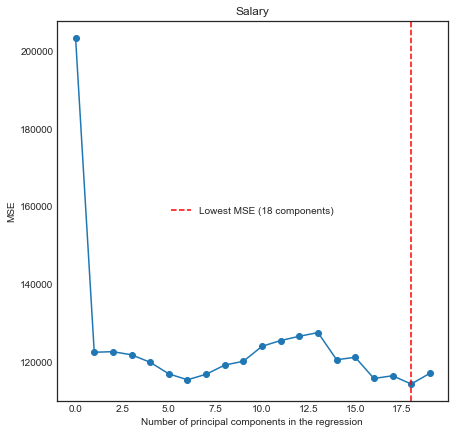

In [37]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
plt.figure(figsize=(7, 7))    
plt.plot(mse, '-o')
plt.xlabel('Number of principal components in the regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);
plt.axvline(18, linestyle="--", color="r", label="Lowest MSE (18 components)")
plt.legend(loc='center')

In [38]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

### (e) PCA with Training Data

scale function properly normalizes the variables

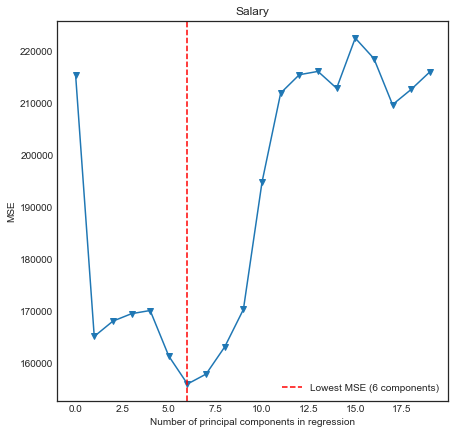

In [39]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 PCs, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
plt.figure(figsize=(7, 7))  
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.axvline(6, linestyle="--", color="r", label="Lowest MSE (6 components)")
plt.legend(loc='best')
plt.xlim(xmin=-1);

In [40]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

96320.02078250323

## III. Example of Partial Least Squares (PLS)

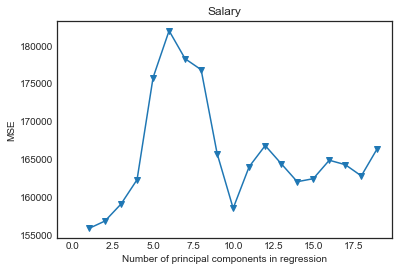

In [50]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=0)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [42]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

102234.27995999216

good to run test errors and compare with training, but its not a one to one comparison. use test mse

##  IV. Example of PCA using the Iris Dataset
Example adapted from [M. Galarnik](https://medium.com/@GalarnykMichael).

In [43]:
import pandas as pd
# Load data from UCI's archive
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

### (a) Standardize the features

In [44]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

###  (b) PCA Estimates: Project 4D (4 features) $\ \rightarrow$  2D (2 PCs)

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

### (c) Display the PCs

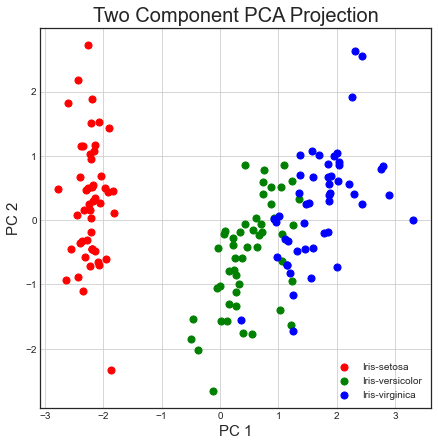

In [46]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Two Component PCA Projection', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### (d) Explained Variance by the PCs

In [47]:
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])